# Natural Language Processing with Disaster Tweets

In this competition, we will build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. If the Tweets are about real disasters, we will predict a 1. If not, we will predict a 0.
We have a dataset of 10,000 tweets that were hand classified. 
https://www.kaggle.com/competitions/nlp-getting-started/overview


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU
from keras.layers import Dense, Embedding, Bidirectional, Dropout, Flatten,SimpleRNN
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,classification_report
import keras

2024-04-28 19:44:20.120988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 19:44:20.121060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 19:44:20.122652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data
Columns:
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)
First, we will load training and test data into pandas dataframe.

In [2]:
#import data 
training=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# Exploratory Data Analysis

The training data has 7613 rows and 5 columns. The test data has 3263 rows and 4 columns.

In [3]:
training.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [4]:
training.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shape of training data
training.shape

(7613, 5)

We will make a histogram to see the number of labels in the target that are real disaster tweets and the number of labels in the target that are not real disaster tweets.

(array([4342.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3271.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

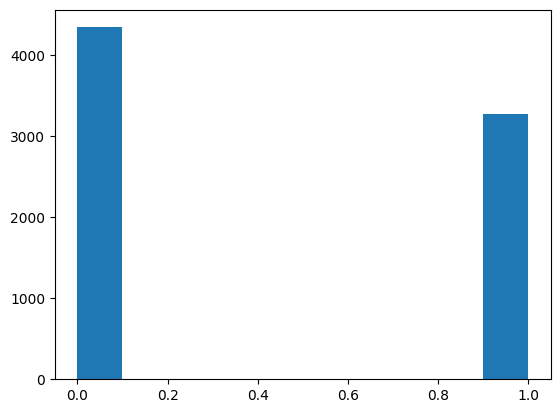

In [6]:
# Histogram on training data
plt.hist(training["target"])

In [7]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [9]:
# Shape of test data
test.shape

(3263, 4)

In [10]:
# Dropping the extra colums
train = training.drop(['id', 'keyword', 'location'], axis=1)
test = test.drop(['id', 'keyword', 'location'], axis=1)

We will split the data into training and validation data using train_test_split and select 20% of the data for validation and 80% of data for training.

In [11]:
# Splitting the data into training and validation data
from sklearn.model_selection import train_test_split
X = train["text"]
y = train["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
X_test = test['text'].values.reshape(len(test),)

We will use Tokenizer to preprocess text required by our text-based models and find the vocabulary size.

In [13]:
total_tweets = np.concatenate((X_train,X_val,X_test))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_tweets)

# Finding the vocabulary Size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary : ', vocab_size)

Vocabulary :  29320


In [14]:
# Finding the maximum length of tweet
maxlen = max(len(x.split()) for x in total_tweets)
print('Maximum length of tweet : ', maxlen)

Maximum length of tweet :  31


tokenizer.texts_to_sequences method is used to convert texts into sequences of integers.

In [15]:
#  Converting texts to sequences
X_train_token = tokenizer.texts_to_sequences(X_train)
X_val_token = tokenizer.texts_to_sequences(X_val)
X_test_token = tokenizer.texts_to_sequences(X_test)

Below we can see how the text in row 1 of training data is converted into sequences of integers.

In [16]:
# Example
print(X_train[1])
print(X_train_token[1])

Forest fire near La Ronge Sask. Canada
[8815, 8816, 8817, 516, 5, 2277, 46, 18, 2278, 4628, 2544, 489, 7, 241, 8818]


We will pad the sequences to the maximum length of tweet to ensure uniform input size.

In [17]:
# Padding the data to keep the length equal
X_train_pad = pad_sequences(X_train_token, maxlen=maxlen, padding='post')
X_val_pad = pad_sequences(X_val_token, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_token, maxlen=maxlen, padding='post')

In [18]:
# Example
print(X_train_token[1])
print("length of X_train_token[1]",len(X_train_token[1]))

print(X_train_pad[1])
print("length of X_train_pad[1] after padding",len(X_train_pad[1]))

[8815, 8816, 8817, 516, 5, 2277, 46, 18, 2278, 4628, 2544, 489, 7, 241, 8818]
length of X_train_token[1] 15
[8815 8816 8817  516    5 2277   46   18 2278 4628 2544  489    7  241
 8818    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
length of X_train_pad[1] after padding 31


In the above example we see that the length of X_train_token[1] is 15 but after padding the length of X_train_pad[1] becomes equal to Maximum length of tweet i.e. 31. 

# SimpleRNN Model

First, we will the build model using SimpleRNN (Simple Recurrent Neural Network). SimpleRNNs are used for NLP(Natual Language Processing) tasks because they can capture sequential dependencies in text data and learn patterns within sentences and are easy to implement. They are faster to train on smaller datasets.

We will use embedding layer to learn word embeddings, which will allow the model to generalize better to unseen words and understand the relationships between words. We use Dense layer to perform linear transformations followed by non linear activation functions, allowing the model to learn complex mappings from input data to output predictions. We use ReLU(Rectified Linear Unit) in the hidden layer as it helps alleviate the vanishing gradient problem by avoiding saturation for positive inputs. We use Sigmoid activation function in the output layer as it is commonly used for binary classification(output needs to be between 0 and 1). We add a droput layer for regularization to prevent overfitting.It randomly drops units during training, forcing the network to learn more robust and generalizable representations of the data.


In [19]:
# Model creation
model2 =Sequential([
    Embedding(input_dim=vocab_size,output_dim=32,input_length=maxlen),
    SimpleRNN(units=32, return_sequences = True), # SimpleRNN with 32 units
    SimpleRNN(units=64), # SimpleRNN with 64 units
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(units=1,activation='sigmoid') # Output layer for binary classification.
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
# model compliation
model2.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

We will use early stopping so that we do not ovefit the model using EarlyStopping from tensorflow.keras.

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
mini_batch_size = 32
epochs = 10
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
# Fitting the model
model2_history = model2.fit(X_train_pad, y_train, 
                          batch_size=mini_batch_size, 
                          epochs=epochs,validation_data=(X_val_pad,y_val)
                            ,callbacks=[early_stopping])


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6525 - loss: 0.6233 - val_accuracy: 0.7722 - val_loss: 0.4949
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8805 - loss: 0.3063 - val_accuracy: 0.7741 - val_loss: 0.5152
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9444 - loss: 0.1459 - val_accuracy: 0.7288 - val_loss: 0.6069
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9793 - loss: 0.0605 - val_accuracy: 0.7531 - val_loss: 0.8501


In [22]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 31, 32)         │       938,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 31, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,890,277 (11.03 MB)

 Trainable params: 963,425 (3.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,926,852 (7.35 MB)

In [23]:
# Generate predictions for the test data
pred = model2.predict(X_test_pad)

# Print the prediction scores
print("Prediction scores")
print(pred)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Prediction scores
[[0.21445353]
 [0.53747797]
 [0.9116836 ]
 ...
 [0.8806354 ]
 [0.7051954 ]
 [0.17557795]]


### SimpleRNN Model Results

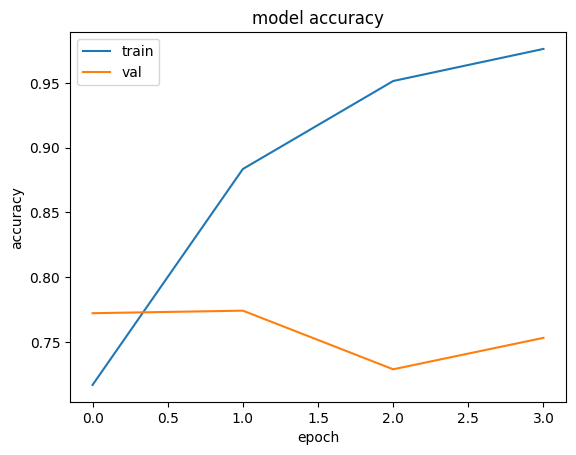

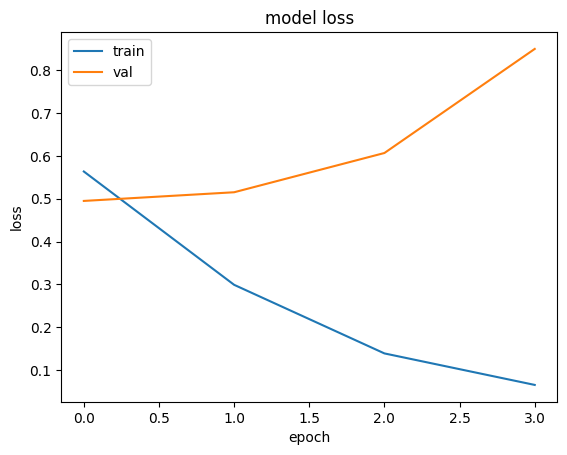

In [24]:
# Accuracy Plot
plt.plot(model2_history.history['accuracy'])
plt.plot(model2_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# loss Plot
plt.plot(model2_history.history['loss'])
plt.plot(model2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


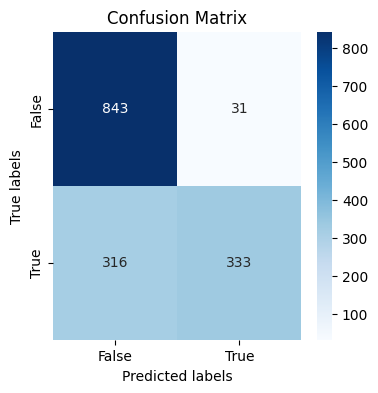

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the classes for validation data
y_pred = model2.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix using Seaborn
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues")  # fmt='d' for integer format
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

# Display the plot
plt.show()

In [26]:
y_pred = model2.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Converting probabilities to binary predictions

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)  

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Precision: 0.9148351648351648
Recall: 0.5130970724191063
F1 Score: 0.6574531095755182
ROC-AUC: 0.7388139824338094


In [27]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83       874
           1       0.91      0.51      0.66       649

    accuracy                           0.77      1523
   macro avg       0.82      0.74      0.74      1523
weighted avg       0.81      0.77      0.76      1523



# LSTM Model

Now we will use LSTM(Long Short-Term Memory) model for disaster tweets classification, as it is specifically designed to address the vanishing gradient problem by capturing long term dependencies in sequences. They perform better on tasks that require understanding context over long sequences. LSTM mostly offers superior performance compared to SimpleRNN for sequence modeling tasks.

We will specifically use Bidirectional LSTM here as it is a powerful variant of LSTM that leverages information from both past and future states of the input sequence to better capture contextual dependencies. We will use embedding layer to learn word embeddings, which will allow the model to generalize better to unseen words and understand the relationships between words.

We will use embedding layer to learn word embeddings, which will allow the model to generalize better to unseen words and understand the relationships between words. We use Dense layer to perform linear transformations followed by non linear activation functions, allowing the model to learn complex mappings from input data to output predictions. We use ReLU(Rectified Linear Unit) in the hidden layer as it helps alleviate the vanishing gradient problem by avoiding saturation for positive inputs. We use Sigmoid activation function in the output layer as it is commonly used for binary classification(output needs to be between 0 and 1). We add a droput layer for regularization to prevent overfitting.It randomly drops units during training, forcing the network to learn more robust and generalizable representations of the data.


In [28]:
# Model Creation
hidden_units = 256
embed_units = 200

model = Sequential()
model.add(Embedding(vocab_size, embed_units, input_length = maxlen))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [30]:
mini_batch_size = 32
epochs = 10
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
# Model Fitting
model_history = model.fit(X_train_pad, y_train, 
                          batch_size=mini_batch_size, 
                          epochs=epochs,validation_data=(X_val_pad,y_val)
                         ,callbacks=[early_stopping])

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.6781 - loss: 0.5877 - val_accuracy: 0.8089 - val_loss: 0.4416
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.9001 - loss: 0.2597 - val_accuracy: 0.7925 - val_loss: 0.4731
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.9601 - loss: 0.1260 - val_accuracy: 0.7827 - val_loss: 0.5715
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - accuracy: 0.9832 - loss: 0.0508 - val_accuracy: 0.7623 - val_loss: 0.6458


In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 31, 200)        │     5,864,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │       935,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,794,565 (79.32 MB)

 Trainable params: 6,931,521 (26.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,863,044 (52.88 MB)

In [32]:
# Generate predictions for the test data
pred = model.predict(X_test_pad)

# Print the prediction scores
print("Prediction scores:")
print(pred)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
Prediction scores:
[[0.37242252]
 [0.5802488 ]
 [0.8083874 ]
 ...
 [0.83722633]
 [0.6907992 ]
 [0.5573742 ]]


In [33]:
# # For the submission File
# pred = model.predict(X_test_pad)
# prediction = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
# prediction["target"] = pred
# prediction["target"] = prediction["target"].apply(lambda x : 0 if x<=.5 else 1)
# prediction.to_csv("predictions.csv", index=False)

### LSTM Model Results

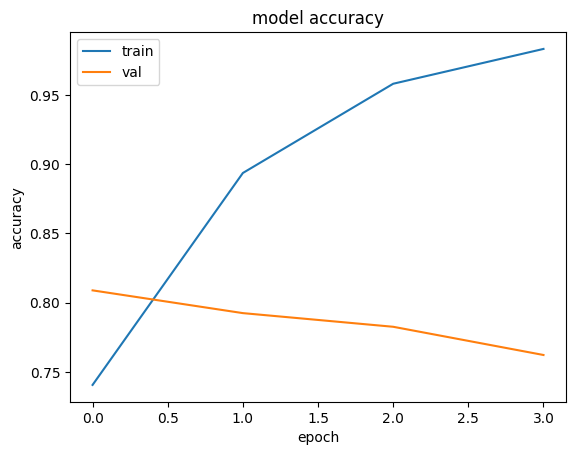

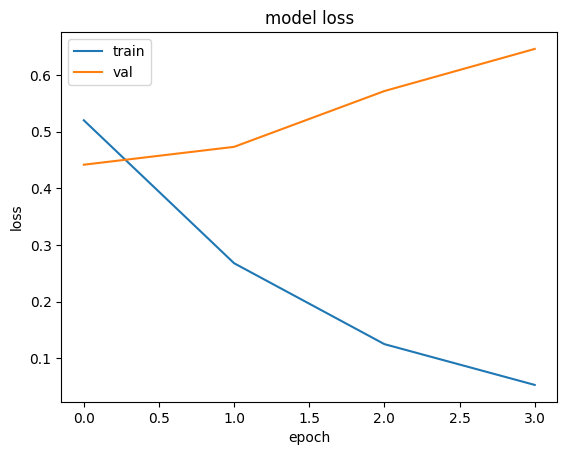

In [34]:
# Accuracy Plot
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# loss Plot
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


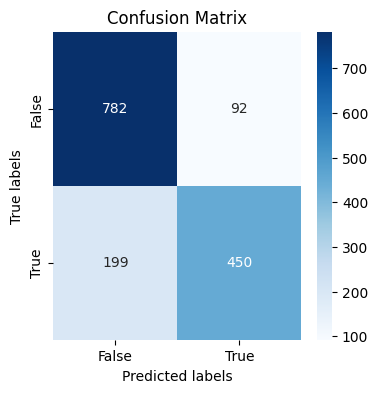

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the classes for validation data
y_pred = model.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix 
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues")  # fmt='d' for integer format
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

# Display the plot
plt.show()

In [36]:
y_pred = model.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)  


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Precision: 0.8302583025830258
Recall: 0.6933744221879815
F1 Score: 0.7556675062972292
ROC-AUC: 0.7940556321466223


In [37]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       874
           1       0.83      0.69      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523



# GRU
GRU(Gated Recurent Unit) is computationally less expensive than LSTM but is still capable of capturing long term dependencies. Similar to LSTM it also addresses the vanishing gradient problem. We will specifically use Bidirectional GRU in our model as it combines the benefits of bidirectional processing with the efficiencyand simplicity of GRU Model.


We will use embedding layer to learn word embeddings, which will allow the model to generalize better to unseen words and understand the relationships between words.
We use Dense layer with Sigmoid activation function in the output layer as it is commonly used for binary classification(output needs to be between 0 and 1). We add a droput for regularization to prevent overfitting. It randomly drops units during training, forcing the network to learn more robust and generalizable representations of the data.


In [38]:
# Model Creation
model3 =Sequential([
    Embedding(input_dim=vocab_size,output_dim=32,input_length=maxlen),
    Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.2, return_sequences = True)),
    Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.2)),
    Dense(units=1,activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
model3.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [40]:
mini_batch_size = 32
epochs = 10
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
# Fitting the Model
model3_history = model3.fit(X_train_pad, y_train, 
                          batch_size=mini_batch_size, 
                          epochs=epochs,validation_data=(X_val_pad,y_val)
                           ,callbacks=[early_stopping])


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - accuracy: 0.6313 - loss: 0.6288 - val_accuracy: 0.7643 - val_loss: 0.5207
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.8568 - loss: 0.3531 - val_accuracy: 0.7669 - val_loss: 0.4770
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.9237 - loss: 0.2163 - val_accuracy: 0.7498 - val_loss: 0.5299
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.9276 - loss: 0.1885 - val_accuracy: 0.7249 - val_loss: 0.5734
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.9661 - loss: 0.0940 - val_accuracy: 0.7347 - val_loss: 0.5807


In [41]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 31, 32)         │       938,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 31, 256)        │       124,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,078,085 (15.56 MB)

 Trainable params: 1,359,361 (5.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,718,724 (10.37 MB)

In [42]:
# Generate predictions for the test data
pred = model3.predict(X_test_pad)

# Print the prediction scores
print("Prediction scores:")
print(pred)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
Prediction scores:
[[0.58541954]
 [0.72645396]
 [0.7408481 ]
 ...
 [0.95864964]
 [0.79413813]
 [0.69376326]]


### GRU Results

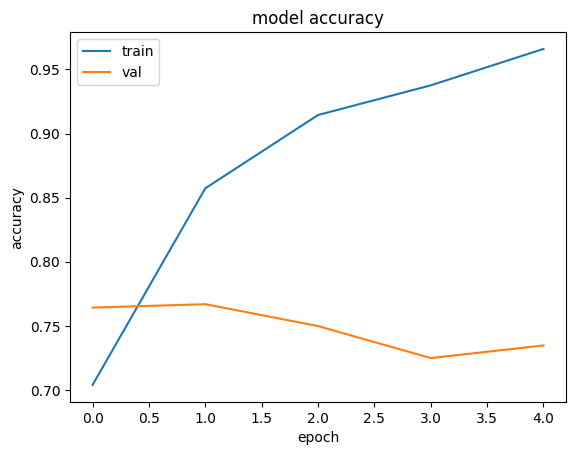

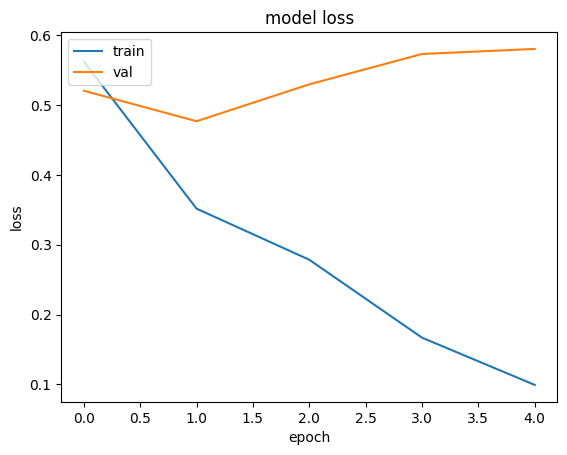

In [43]:
# Accuracy plot

plt.plot(model3_history.history['accuracy'])
plt.plot(model3_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# loss plot
plt.plot(model3_history.history['loss'])
plt.plot(model3_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


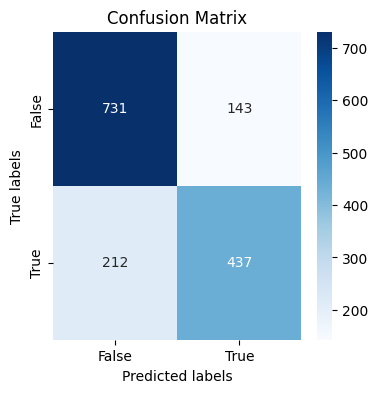

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the classes for validation data
y_pred = model3.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues")  # fmt='d' for integer format
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

# Display the plot
plt.show()


In [45]:
y_pred = model3.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)  


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Precision: 0.753448275862069
Recall: 0.6733436055469953
F1 Score: 0.711147274206672
ROC-AUC: 0.7548640224531314


In [46]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.80       874
           1       0.75      0.67      0.71       649

    accuracy                           0.77      1523
   macro avg       0.76      0.75      0.76      1523
weighted avg       0.77      0.77      0.76      1523



# Results and Conclusion

From the classification reports of all the three models we see that for:

**Simple RNN model:**
* Accuracy: 0.772
* Precision: 0.9148351648351648
* Recall: 0.5130970724191063
* F1 Score: 0.6574531095755182
* ROC-AUC: 0.7388139824338094
* 843 True Negatives and 333 True Positives
* 31 False Positives and 316 False Negatives

**For LSTM model:**
* Accuracy: 0.808
* Precision: 0.8302583025830258
* Recall: 0.6933744221879815
* F1 Score: 0.7556675062972292
* ROC-AUC: 0.7940556321466223
* 782 True Negatives and 450 True Positives
* 92 False Positives and 199 False Negatives

**For GRU model:**
* Accuracy: 0.767
* Precision: 0.753448275862069
* Recall: 0.6733436055469953
* F1 Score: 0.711147274206672
* ROC-AUC: 0.7548640224531314
* 731 True Negatives and 437 True Positives
* 143 False Positives and 212 False Negatives


**Conclusion:**
* LSTM model has highest Accuracy: 80.8%
* Simple RNN model has highest Precision: 91.48%
* LSTM model has highest Recall: 69.33%
* LSTM model has highest F1 score: 75.56%
* LSTM model has highest ROC-AUC: 79.40%
* We need to improve these models by reducing the validation loss.
* We need to increase the accuracy, precision, recall and F1-score on the validation data. 
* We need to reduce the number of False Negatives.
* We may reduce the number of units in Dense layer to reduce overfitting on validation data, as our model is performing better on training data compared to validation data.
* We may increase the dropout rate to reduce overfitting on validation data, as our model is performing better on training data compared to validation data.

Simple RNN model is the most precise among the three models as it is 91.48% precise.
Overall, LTSM is performing the best among the three models that we have created based on Accuracy, Recall, F1 Score and ROC-AUC. 